# Ocean Emulation Animations with U-Net

To run this notebook, you will have to use LEAP-Pangeo hub!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fsrc%2Fnotebooks%2Funet_movie.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

We showcase Ocean emulation in the Gulf Stream region produced by a trained U-Net model's predictions. 

The data used by the model includes : 

i. Ocean state $\phi = (u, v, T)$, which represents the zonal velocity, meridional velocity, and temperature, respectively, in the surface layer. 

ii. Atmosphere boundary conditions $\tau = (\tau_u, \tau_v, T_{atm})$, which represent the zonal wind stress, meridional wind stress, and air temperature, respectively.

iii. Lateral boundary conditions $\phi' = (u, v, T)$ at the boundaries of the Gulf Stream region. The model uses $Nb$ points on the boundary.

The model takes in an input vector with 9 channels: three channels correspond to the ocean state $\phi_{t-1}$, three channels for the atmospheric boundary $\tau_t$, and another three channels for the lateral boundary conditions $\phi_{t}'$ with $Nb = 4$ and predicts the next ocean state $\phi_{t}$. We retrieve the predictions from a saved data store rather than running the model in this notebook.

Credits: [https://arxiv.org/pdf/2402.04342.pdf](https://arxiv.org/pdf/2402.04342.pdf)

In [13]:
import cartopy.crs as ccrs
import cartopy as cart
import cmocean
from matplotlib.animation import FuncAnimation
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import numpy as np

Let us first retrieve the relevant data. We first retrieve the grid data corresponding to the location the U-Net was trained on. We also retrieve data corresponding to the wet mask in the region of interest. Then, we get the data corresponding to the ground truth and the prediction of the U-Net. 

In [14]:
grids = xr.open_dataset(
    "gs://leap-persistent/m2lines-data-gallery/grids.nc", engine="zarr"
)
wet_nan = (
    xr.open_dataset(
        "gs://leap-persistent/m2lines-data-gallery/wet_nan.npy", engine="zarr"
    )
    .to_dataarray()
    .to_numpy()[0]
)

ground_truth = (
    xr.open_dataset(
        "gs://leap-persistent/m2lines-data-gallery/ground_truth.npy", engine="zarr"
    )
    .to_dataarray()
    .to_numpy()[0]
)
model_pred_unet = (
    xr.open_dataset(
        "gs://leap-persistent/m2lines-data-gallery/model_pred_unet.npy", engine="zarr"
    )
    .to_dataarray()
    .to_numpy()[0]
)

The shape of the predictions and ground truth are - [Time, Channels, Height, Width]

In [15]:
print(ground_truth.shape)
assert ground_truth.shape == model_pred_unet.shape
assert ground_truth.shape[2:] == wet_nan.shape

(3000, 3, 119, 189)


We will show the animation for 1000 steps and set the lateral boundary to the same value during training. 

In [16]:
N_plot = 1000
Nb = 4  # Boundary Condition

Denormalization constants

In [17]:
mean_out = np.array([4.48182137e-02, -1.05207746e-02, 1.21086583e01])
std_out = np.array([0.15139965, 0.14337273, 9.03747046])

Matplotlib constants and functions based on type of channel predicted

In [18]:
var_list = {
    "0": r"$\bar{u}~~\mathrm{(m/s)}$",
    "1": r"$\bar{v}~~\mathrm{(m/s)}$",
    "2": r"$\bar{T} ~ (^\circ C)$",
}


def get_vmin_vmax(ind_plot):
    vmin = mean_out[ind_plot] - std_out[ind_plot]
    vmax = mean_out[ind_plot] + std_out[ind_plot]
    if ind_plot == 2:
        vmin = mean_out[ind_plot] - (1.75 * std_out[ind_plot])
        vmax = mean_out[ind_plot] + (1.75 * std_out[ind_plot])

    if ind_plot in [0, 1]:
        vmin -= std_out[ind_plot]
        vmax += std_out[ind_plot]
        limit = np.round(np.max([abs(vmin), abs(vmax)]), 1)
        vmin = -limit
        vmax = limit
    return vmin, vmax


def get_cmap(ind_plot):
    if ind_plot == 2:
        cmap = cmocean.cm.thermal
    else:
        cmap = cmocean.cm.diff
    return cmap

In [19]:
def get_fig_axs():
    plt.rcParams.update({"font.size": 15})
    fig, axs = plt.subplots(
        2,
        2,
        figsize=(12, 5),
        gridspec_kw={
            "width_ratios": [1, 1],
            "height_ratios": [1, 1],
            "wspace": 0.25,
            "hspace": 0.5,
        },
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    return fig, axs

Let us plot one frame of the ground truth and prediction.

In [20]:
def plot_single_snapshot(ind_plot):

    fig, axs = get_fig_axs()
    vmin, vmax = get_vmin_vmax(ind_plot)
    cmap = get_cmap(ind_plot)

    x_plot = grids["x_C"][Nb:-Nb, Nb:-Nb]
    y_plot = grids["y_C"][Nb:-Nb, Nb:-Nb]

    plt0 = axs[0, 0].pcolormesh(
        x_plot,
        y_plot,
        ground_truth[N_plot - 1][ind_plot, Nb:-Nb, Nb:-Nb]
        * wet_nan[Nb:-Nb, Nb:-Nb]
        * std_out[ind_plot]
        + mean_out[ind_plot],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        shading="auto",
    )

    axs[0, 0].add_feature(cart.feature.LAND, zorder=100, edgecolor="k")
    gl = axs[0, 0].gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.yrotation = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    axs[0, 0].set_title(r"CM2.6", size=15)

    pos = axs[1, 1].get_position()

    # Set the new anchor point to be in the middle
    new_pos = [
        pos.x0 - 0.075,
        pos.y0 + 0.15,
        pos.width * 1.75,
        pos.height * 1.5,
    ]  # Adjust 0.2 as needed

    # Create a new axes with the adjusted position
    cax = fig.add_axes(new_pos)

    cbar = plt.colorbar(plt0, ax=cax, orientation="horizontal", aspect=10)
    cbar.ax.tick_params(labelsize=16)  # Set the font size for tick labels
    if ind_plot == 2:
        cbar.set_ticks([np.ceil(vmin), np.round((vmin + vmax) / 2), np.floor(vmax)])
    else:
        cbar.set_ticks([vmin, 0, vmax])

    cbar.set_label(var_list[str(ind_plot)], fontsize=20)

    fig.delaxes(axs[1, 1])
    fig.delaxes(cax)

    plt1 = axs[0, 1].pcolormesh(
        x_plot,
        y_plot,
        model_pred_unet[N_plot - 1, ind_plot, Nb:-Nb, Nb:-Nb] * wet_nan[Nb:-Nb, Nb:-Nb],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        shading="auto",
    )

    axs[0, 1].add_feature(cart.feature.LAND, zorder=100, edgecolor="k")
    gl = axs[0, 1].gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.yrotation = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    axs[0, 1].set_title(r"Unet($\phi_{t-1}, \tau_{t}, \phi_{t}'$)", size=15)

    axs[1, 0].set_axis_off()

    a = fig.suptitle(
        r"UNet model rollout " + ": $t = " + str(N_plot) + "$ days ",
        fontsize=16,
    )

    return fig, plt0, plt1, a

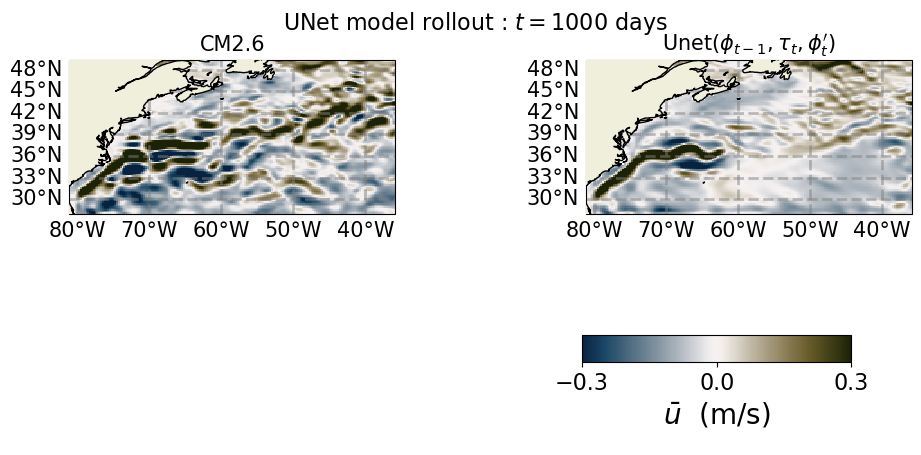

In [21]:
ind_plot = 0
fig, plt0, plt1, a = plot_single_snapshot(ind_plot)

Now, an update function to update the plot for each frame of the animation.

In [22]:
def update(i):
    plt0.set_array(
        (
            ground_truth[i][ind_plot, Nb:-Nb, Nb:-Nb]
            * wet_nan[Nb:-Nb, Nb:-Nb]
            * std_out[ind_plot]
            + mean_out[ind_plot]
        ).flatten()
    )
    plt1.set_array(
        (
            model_pred_unet[i, ind_plot, Nb:-Nb, Nb:-Nb] * wet_nan[Nb:-Nb, Nb:-Nb]
        ).flatten()
    )
    a.set_text(r"UNet model rollout " + ": $t = " + str(i + 1) + "$ days ")

Finally, we create the animation object and save it. We save the animation every 10 frames to speed up the process.

In [23]:
anim = FuncAnimation(fig, update, interval=100, frames=range(0, 1000, 10))
anim.save("u.gif")

Here, I have saved the animation for every 2 steps.

![](../assets/Unet_u.gif)


Let us now save the animations for the other channels and save them.

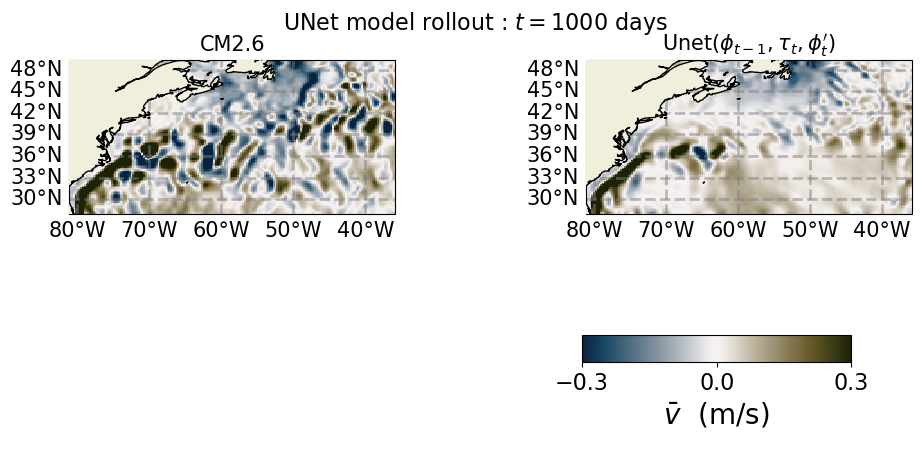

In [24]:
ind_plot = 1
fig, plt0, plt1, a = plot_single_snapshot(ind_plot)

In [25]:
anim = FuncAnimation(fig, update, interval=100, frames=range(0, 1000, 10))
anim.save("v.gif")

Saved Gif :

![](../assets/Unet_v.gif)


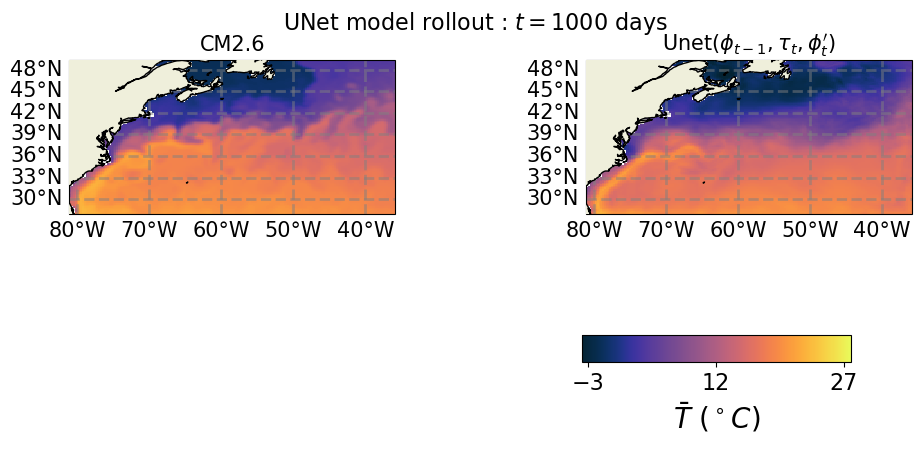

In [26]:
ind_plot = 2
fig, plt0, plt1, a = plot_single_snapshot(ind_plot)

In [27]:
anim = FuncAnimation(fig, update, interval=100, frames=range(0, 1000, 10))
anim.save("T.gif")

Saved Gif: 

![](../assets/Unet_T.gif)